from: http://mc-stan.org/users/documentation/case-studies/qr_regression.html

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(123)

import theano.tensor as tt
import pymc3 as pm
import patsy
import pandas as pd

In [2]:
N = 5000
x = np.random.normal(10, 1, size=N)
x2 = np.power(x, 2)

X = np.stack((np.ones_like(x), x, x2), axis=1)


beta_true = np.atleast_2d(np.array([-0.275, 2.5, -1.0])).T

sd_true = 0.8
mu_true = np.dot(X, beta_true)
y = np.random.normal(mu_true, sd_true)

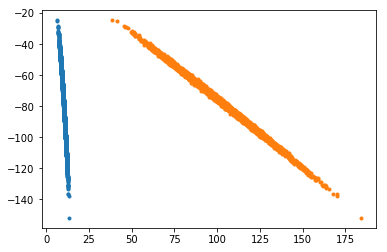

In [3]:
plt.plot(x, y, '.'), plt.plot(x2, y, '.');

In [4]:
X[:5, :]

array([[  1.        ,   8.9143694 ,  79.46598174],
       [  1.        ,  10.99734545, 120.94160687],
       [  1.        ,  10.2829785 , 105.73964679],
       [  1.        ,   8.49370529,  72.14302949],
       [  1.        ,   9.42139975,  88.76277321]])

In [5]:
with pm.Model() as model:
    
    beta = pm.Normal('beta', mu=0, sd=10, shape=X.shape[1])
    mu = tt.dot(X, beta)
    
    sd = pm.HalfNormal('sd', sd=10)
    
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=y.flatten())
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=4, random_seed=123, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta]
Sampling 4 chains: 100%|████████████████████████████████████████████████████████████████████| 8000/8000 [05:17<00:00,  7.77draws/s]
The number of effective samples is smaller than 25% for some parameters.


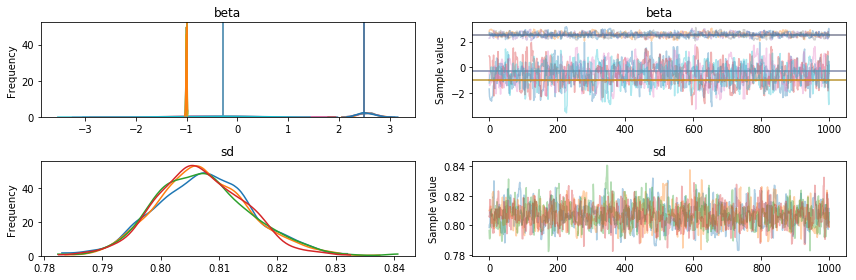

In [6]:
pm.traceplot(trace, lines={'beta':beta_true});

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.520509,0.843383,0.030456,-2.228426,1.040199,758.660575,1.001801
beta__1,2.547496,0.168686,0.006095,2.240693,2.896313,761.788278,1.002009
beta__2,-1.002287,0.008396,0.000303,-1.019690,-0.986903,770.647044,1.002229
sd,0.807106,0.007910,0.000199,0.792988,0.824048,1078.476500,1.000025


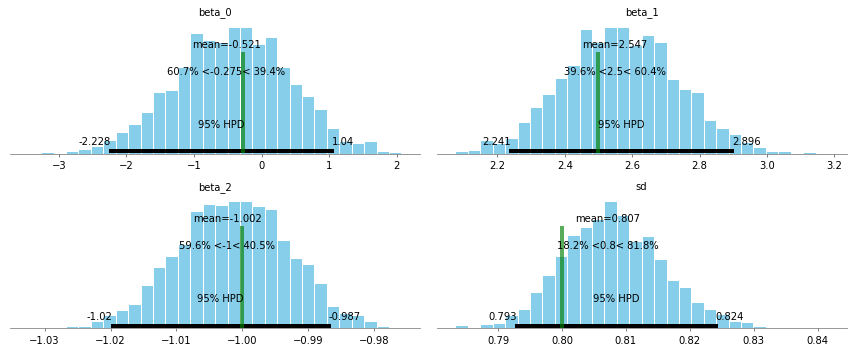

In [8]:
pm.plot_posterior(trace, ref_val=np.append(beta_true.flatten(), sd_true));

## QR decomposition

In [9]:
Q, R = np.linalg.qr(X)
Q = Q * N
R = R / N
R_inv = np.linalg.inv(R)

Q.shape, R.shape

((5000, 3), (3, 3))

In [10]:
Q

array([[-70.71067812,  79.2255897 ,  10.82376762],
       [-70.71067812, -69.88708251,   0.6830972 ],
       [-70.71067812, -18.74815336, -46.57122157],
       ...,
       [-70.71067812, 134.63948418, 129.35214819],
       [-70.71067812, -63.90795685,  -7.57592344],
       [-70.71067812,  98.42570749,  44.85171523]])

In [11]:
with pm.Model() as model:
    
    beta_tilde = pm.Normal('beta_tilde', mu=0, sd=1, shape=X.shape[1])
    beta = pm.Deterministic('beta', tt.dot(R_inv, beta_tilde))
    
    mu = tt.dot(Q, beta_tilde)
    sd = pm.HalfNormal('sd', sd=10)
    
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=y.flatten())
    trace = pm.sample(draws=1000, tune=1000, chains=4, cores=4, random_seed=123, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta_tilde]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████████████████| 8000/8000 [00:20<00:00, 524.68draws/s]


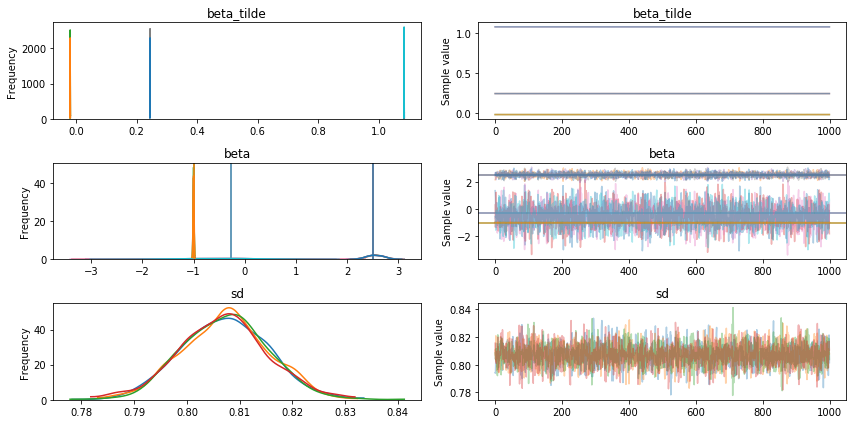

In [12]:
pm.traceplot(trace, lines={'beta':beta_true});

In [13]:
pm.summary(trace, varnames=['beta', 'sd'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-0.535121,0.852780,0.010442,-2.118556,1.209849,5585.154566,0.999547
beta__1,2.550343,0.171210,0.002097,2.211556,2.880490,5594.194622,0.999547
beta__2,-1.002422,0.008545,0.000105,-1.018561,-0.985245,5594.690638,0.999546
sd,0.807088,0.008184,0.000129,0.791578,0.823151,4138.616318,0.999937


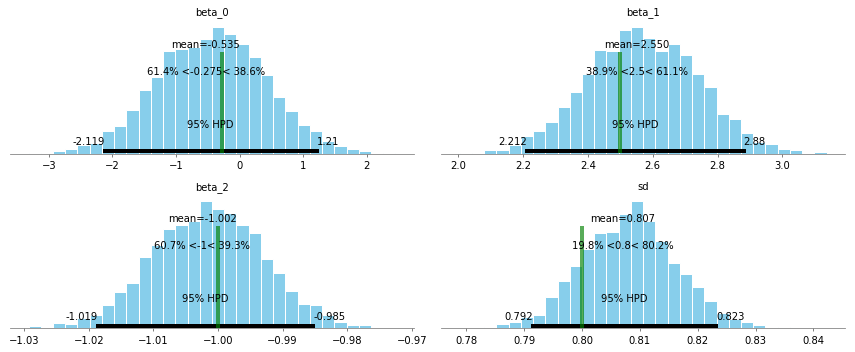

In [14]:
pm.plot_posterior(trace, varnames=['beta', 'sd'], ref_val=np.append(beta_true.flatten(), sd_true));